In [66]:
# Pandas is used for data manipulation
import pandas as pd

# Use numpy to convert to arrays
import numpy as np

# Read in data and display first 5 rows
features = pd.read_csv('solardata.csv', sep='\t')
features.head(5)

,HourOfDay,DayOfWeek,WeekOfYear,Month,SolarSurface,AvgGenArea,Consumed,UvIndex,GeneratedSolar
0,0,2,1,1,15.0,1.0,677.0,0.0,13.95
1,0,2,1,1,10.0,1.0,3050.0,0.0,10.60
2,0,2,1,1,8.0,1.0,3743.0,0.0,8.40
3,0,2,1,1,8.0,1.0,2445.0,0.0,8.64
4,0,2,1,1,12.0,1.0,1762.0,0.0,12.24


In [67]:
# Labels are the values we want to predict
labels = np.array(features['GeneratedSolar'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('GeneratedSolar', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.5, random_state = 42)

print(test_features[0])

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('AvgGenArea')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)

print('Average baseline error: ', round(np.mean(baseline_errors), 2))

[1.400e+01 1.000e+00 7.000e+00 2.000e+00 8.000e+00 1.610e+02 3.868e+03
 1.000e+01]
Training Features Shape: (43800, 8)
Training Labels Shape: (43800,)
Testing Features Shape: (43800, 8)
Testing Labels Shape: (43800,)
Average baseline error:  1604.1


In [68]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with x decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);
print('Done')

Done


In [69]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kwh.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 93.95 kwh.
Accuracy: 94.7 %.


In [70]:
# Import tools needed for visualization
#from sklearn.tree import export_graphviz
#import pydot

# Pull out one tree from the forest
#tree = rf.estimators_[0]

# Export the image to a dot file
#export_graphviz(tree, out_file = './tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('./tree.dot')

# Write graph to a png file
#graph.write_png('./tree.png')
#from IPython.display import Image
#Image(filename='./tree.png') 

In [71]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: AvgGenArea           Importance: 0.48
Variable: UvIndex              Importance: 0.43
Variable: SolarSurface         Importance: 0.09
Variable: HourOfDay            Importance: 0.0
Variable: DayOfWeek            Importance: 0.0
Variable: WeekOfYear           Importance: 0.0
Variable: Month                Importance: 0.0
Variable: Consumed             Importance: 0.0


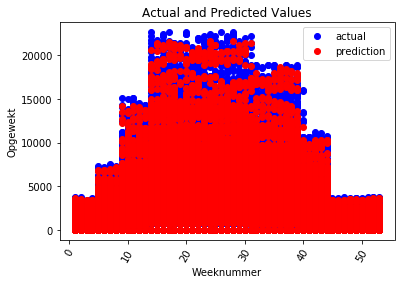

In [72]:
# Use datetime for creating date objects for plotting
import datetime
import matplotlib.pyplot as plt
# Dates of training values
week_nr = features[:, feature_list.index('WeekOfYear')]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'week': week_nr, 'actual': labels})

# Dates of predictions
test_week_nr = test_features[:, feature_list.index('WeekOfYear')]
predictions_data = pd.DataFrame(data = {'week': test_week_nr, 'prediction': predictions})

# Plot the actual values
plt.plot(true_data['week'], true_data['actual'], 'bo', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['week'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Weeknummer'); plt.ylabel('Opgewekt'); plt.title('Actual and Predicted Values');

In [73]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [74]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

#[ 15.   3.  31.   7.  15. 289. 839.  18.]
hourOfDay = 14.
dayOfWeek = 6.
weekOfYear = 51.
month = 3.
solarSurface = 17.
avgGenArea = 228.8923089
consumed = 204.1255672
uvIndex = 5

#score
predict_input = [hourOfDay, dayOfWeek, weekOfYear, month, solarSurface, avgGenArea, consumed, uvIndex]
result = loaded_model.predict([predict_input])
print(result)

[2291.5983]
